In [1]:
import numpy as np
import cv2
import glob
import json
import dlib
import yaml
from imutils import face_utils
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt
from tqdm import tqdm,trange
from PIL import Image
from IPython.display import HTML
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from scipy import interp
import pandas as pd

from common_functions import get_camera_parameters,get_full_image_points,get_full_model_points,eye_aspect_ratio, generate_HTML_CM

In [10]:
# Get All participants
participants = glob.glob('dataset/*') # ['dataset/2cc97c9c49cb4f03ae978d1eb73f304b',....]
# Get clean UUIDs
participants_uuids = [val.split("/")[1] for val in participants]

# EAR threshold
EAR_THRESHOLD = 0.14

In [11]:
# Read FAN data saved in pickle
dtStorage = pd.read_pickle("./FAN_data.pkl")

In [12]:
brokenFrames = []
for index, observation in dtStorage.iterrows():
    try:
        get2DLandmarks = observation['2d'][0,1]
        get3DLandmarks = observation['3d'][0,1]
    except:
        # The FAN could not find a face
        brokenFrames.append(index)
        continue
# I could have done the broken frames removal in one line
# but I couldn't match the None value in 2d cells for some reason
dtStorage = dtStorage.drop(brokenFrames)

In [13]:
def transformDataframe(frame):
    """
    Args:
        frame (pandas dataframe): Dataframe with all the features calculated.
    
    Extra:
        columns: 'UUID','filename', '2d', '3d','class','image_size', 'rotation', translation
    
    Returns:
       features: numpy array with the X rows and 142 features as columns
       labels: numpy array with the X observation labels
    """
    features = np.zeros((frame.shape[0], 142))
    labels = np.zeros(frame.shape[0])

    idx = 0
    for index, observation in frame.iterrows():
        camera_matrix, dist_coeffs = get_camera_parameters(observation['image_size'])
        (success, rotation_vector, translation_vector) = cv2.solvePnP(
                observation['3d'][0], observation['2d'][0], camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)
        features[idx, :] = np.reshape(np.concatenate((observation['rotation'].squeeze(), observation['translation'].squeeze(),observation['2d'][0][:,0], observation['2d'][0][:,1]), axis=0), (142, ))
        labels[idx] = observation['class']
        idx +=1
        
    return (features[:idx,:], labels[:idx])



In [14]:
def generateFeaturesFrame(frame):
    """
    Args:
        frame (pandas dataframe): Dataframe with FAN features.
    
    Extra:
        columns: 'UUID','filename', '2d', '3d','class','image_size'
    
    Returns:
       frame: new frame with all the rotation and translation vectors appended as columns
       to calculate once in the process 
    """
    rotation = []
    translation = []
    for index, observation in frame.iterrows():
        # DEBUG
        # Display image
        whiteFrame = 255 * np.ones((1300,1300,3), np.uint8)
        landmarks = []
        for idx2, p in enumerate(observation['2d'][0]):
            landmarks.append({"index":idx2,'y': p[1], 'x': p[0]})
#             cv2.circle(whiteFrame, (int(p[0]), int(p[1])), 3, (0,0,255), -1)
            #             if idx2 > 35 and idx2 <48:
            #                 cv2.circle(whiteFrame, (int(p[0]), int(p[1])), 3, (0,0,255), -1)
            #         %matplotlib inline
            #         plt.imshow(whiteFrame)
            #         plt.show()
        
        # Blink Detection
        try:
            leftEAR = eye_aspect_ratio(landmarks[36:42])
            rightEAR = eye_aspect_ratio(landmarks[42:48])
        except:
            # If exception is raised it's propably due to C parameter being equal to 0
            # We ignore this observation due to noise
            print("Ignoring noisy sample")
            rotation.append(None)
            translation.append(None)
            print(index)
            continue
        ear = (leftEAR + rightEAR) / 2.0
        if(ear <= EAR_THRESHOLD):
            print("Ignoring closed eye sample")
            # Eyes were closed so I am ignoring this sample
            rotation.append(None)
            translation.append(None)
            print(index)
            continue
        
        camera_matrix, dist_coeffs = get_camera_parameters(observation['image_size'])
        (success, rotation_vector, translation_vector) = cv2.solvePnP(
                observation['3d'][0], observation['2d'][0], camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)
        rotation.append(rotation_vector)
        translation.append(translation_vector)
    
    frame['rotation'] = rotation
    frame['translation'] = translation
    
    return frame[~frame['rotation'].isnull()]

In [20]:
# Accuracy metrics for the whole dataset. These are computed
# by leaving every Subject out one time, calculating the accuracy for each
# one and then taking the mean value.
accuracy_rf_total = 0
accuracy_svm_total = 0
precision_rf = 0
precision_svm = 0

num_features = 142

# Calculate AVG metrics
Confusion_Matrix_SVM = []
Confusion_Matrix_RF = []

# avg ROC creation
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# %matplotlib notebook
fig, ax = plt.subplots()

# Get Clean Data without Blinkes and Noise
# And with Rotation and Translation Vectors Generated
featureData = generateFeaturesFrame(dtStorage)

counter = 0
excludes = 0
# Loop over each participant
for uuid in tqdm(participants_uuids):
    
    subject = featureData[featureData['UUID'] == uuid]
    train_obs = featureData[featureData['UUID'] != uuid]
    (features_val, labels_val) = transformDataframe(subject)
    (features_train, labels_train) = transformDataframe(train_obs)
    
    print("--- Start training SVM Classifier ---")
    svm_classifier = svm.SVC(C=100, kernel='rbf', gamma='scale', probability=True)
    svm_classifier.fit(features_train, labels_train)
    # Predict SVM with threshold at 0.3 instead of 0.5
    #threshold = 0.3
    threshold = 0.5
    y_prob_svm = svm_classifier.predict_proba(features_val)
    y_pred_svm = (y_prob_svm[:, 1] >= threshold).astype(int)
    accuracy_svm_subject = metrics.accuracy_score(labels_val, y_pred_svm)
    
    print("--- Start training RF Classifier ---")
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1)
    rf_classifier.fit(features_train, labels_train)
    y_pred_rf = rf_classifier.predict(features_val)
    
    # ROC metrics
    viz = plot_roc_curve(svm_classifier, features_val, labels_val,
                         response_method='predict_proba',
                         alpha=0.3, lw=1, ax=ax)  

    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    confusion_matrix_svm = metrics.confusion_matrix(labels_val, y_pred_svm)
    confusion_matrix_rf = metrics.confusion_matrix(labels_val, y_pred_rf)
    Confusion_Matrix_SVM.append(confusion_matrix_svm)
    Confusion_Matrix_RF.append(confusion_matrix_rf)
    try:
        if confusion_matrix_rf[1][1] and confusion_matrix_svm[1][1]:
            precision_rf += confusion_matrix_rf[1][1]/(confusion_matrix_rf[1][1] + confusion_matrix_rf[0][1])
            precision_svm += confusion_matrix_svm[1][1]/(confusion_matrix_svm[1][1] + confusion_matrix_svm[0][1])
        else:
            print(confusion_matrix_rf)
            print(confusion_matrix_svm)
            excludes += 1
    except:
        print("--------- Broke ---------")
        excludes += 1
        print(features_val)
        print(labels_train)
        print(labels_val)
    
    accuracy_svm_subject = metrics.accuracy_score(labels_val, y_pred_svm)
    accuracy_rf_subject = metrics.accuracy_score(labels_val, y_pred_rf)
    accuracy_svm_total += accuracy_svm_subject*y_pred_svm.shape[0]
    accuracy_rf_total += accuracy_rf_subject*y_pred_rf.shape[0]
    
    print('#{} TEST SVM: {}, TRAIN SVM: {}'.format(uuid, round(accuracy_svm_subject, 2),
                                      round(svm_classifier.score(features_train, labels_train), 2)))
    print('#{} TEST RF: {}, TRAIN RF: {}'.format(uuid, round(accuracy_rf_subject, 2),
                                      round(rf_classifier.score(features_train, labels_train), 2)))
    counter+=1

Ignoring noisy sample
266
Ignoring closed eye sample
1802




  0%|          | 0/52 [00:00<?, ?it/s]

Ignoring closed eye sample
3369
--- Start training Classifier ---




  2%|▏         | 1/52 [00:16<14:25, 16.96s/it]

#2cc97c9c49cb4f03ae978d1eb73f304b TEST SVM: 0.84, TRAIN SVM: 0.76
#2cc97c9c49cb4f03ae978d1eb73f304b TEST RF: 0.3, TRAIN RF: 1.0
--- Start training Classifier ---




  4%|▍         | 2/52 [00:32<13:51, 16.64s/it]

#80be680d12c84471a3169d1e80b5d7ec TEST SVM: 0.79, TRAIN SVM: 0.76
#80be680d12c84471a3169d1e80b5d7ec TEST RF: 0.51, TRAIN RF: 1.0
--- Start training Classifier ---




  6%|▌         | 3/52 [00:49<13:30, 16.54s/it]

#c823b3cc2ed0484d9759cac9981031ed TEST SVM: 0.56, TRAIN SVM: 0.77
#c823b3cc2ed0484d9759cac9981031ed TEST RF: 0.6, TRAIN RF: 1.0
--- Start training Classifier ---




  8%|▊         | 4/52 [01:07<13:36, 17.02s/it]

#9ed2ca01d30041aab1979f89cfdfa3cd TEST SVM: 0.76, TRAIN SVM: 0.77
#9ed2ca01d30041aab1979f89cfdfa3cd TEST RF: 0.68, TRAIN RF: 1.0
--- Start training Classifier ---




 10%|▉         | 5/52 [01:28<14:13, 18.16s/it]

#3ef8c45b30ec40cb90526280c04dec0a TEST SVM: 0.77, TRAIN SVM: 0.77
#3ef8c45b30ec40cb90526280c04dec0a TEST RF: 0.77, TRAIN RF: 1.0
--- Start training Classifier ---




 12%|█▏        | 6/52 [01:46<14:04, 18.36s/it]

#d824f0d3d56f41b4946aba7c9f6c3cfd TEST SVM: 0.68, TRAIN SVM: 0.77
#d824f0d3d56f41b4946aba7c9f6c3cfd TEST RF: 0.48, TRAIN RF: 1.0
--- Start training Classifier ---




 13%|█▎        | 7/52 [02:05<13:49, 18.43s/it]

#9ef5c8cde44048f092b8625918b04986 TEST SVM: 0.67, TRAIN SVM: 0.76
#9ef5c8cde44048f092b8625918b04986 TEST RF: 0.63, TRAIN RF: 1.0
--- Start training Classifier ---




 15%|█▌        | 8/52 [02:22<13:08, 17.92s/it]

#7a45e3e8ed4b4774ae98254fd364f2ca TEST SVM: 0.54, TRAIN SVM: 0.77
#7a45e3e8ed4b4774ae98254fd364f2ca TEST RF: 0.54, TRAIN RF: 1.0
--- Start training Classifier ---
[[25  1]
 [26  0]]
[[26  0]
 [26  0]]




 17%|█▋        | 9/52 [02:38<12:33, 17.53s/it]

#7c6b6801ba3245bbb10dc6a7b9996d88 TEST SVM: 0.5, TRAIN SVM: 0.77
#7c6b6801ba3245bbb10dc6a7b9996d88 TEST RF: 0.48, TRAIN RF: 1.0
--- Start training Classifier ---




 19%|█▉        | 10/52 [02:55<12:07, 17.32s/it]

#493e717904f744978a20292fb4adddaa TEST SVM: 0.5, TRAIN SVM: 0.77
#493e717904f744978a20292fb4adddaa TEST RF: 0.5, TRAIN RF: 1.0
--- Start training Classifier ---




 21%|██        | 11/52 [03:11<11:36, 16.98s/it]

#05e84e3f8e6344f5baaf003543df8d3a TEST SVM: 0.88, TRAIN SVM: 0.77
#05e84e3f8e6344f5baaf003543df8d3a TEST RF: 0.82, TRAIN RF: 1.0
--- Start training Classifier ---
[[48  0]
 [49  0]]
[[48  0]
 [45  4]]




 23%|██▎       | 12/52 [03:28<11:14, 16.85s/it]

#0656f5fe35a54d1589e526a702f578b0 TEST SVM: 0.54, TRAIN SVM: 0.76
#0656f5fe35a54d1589e526a702f578b0 TEST RF: 0.49, TRAIN RF: 1.0
--- Start training Classifier ---




 25%|██▌       | 13/52 [03:47<11:25, 17.58s/it]

#149797134bae4deaac692a73bf162fe9 TEST SVM: 0.64, TRAIN SVM: 0.77
#149797134bae4deaac692a73bf162fe9 TEST RF: 0.37, TRAIN RF: 1.0
--- Start training Classifier ---




 27%|██▋       | 14/52 [04:05<11:11, 17.68s/it]

#61176f72b54241a2aaac74181926195a TEST SVM: 0.65, TRAIN SVM: 0.77
#61176f72b54241a2aaac74181926195a TEST RF: 0.56, TRAIN RF: 1.0
--- Start training Classifier ---




 29%|██▉       | 15/52 [04:23<10:52, 17.64s/it]

#6ae20e8b86424bc4a624abb83aa2c9f7 TEST SVM: 0.6, TRAIN SVM: 0.77
#6ae20e8b86424bc4a624abb83aa2c9f7 TEST RF: 0.52, TRAIN RF: 1.0
--- Start training Classifier ---




 31%|███       | 16/52 [04:39<10:16, 17.13s/it]

#05d77af9b4ce4de5b0f631f685601d41 TEST SVM: 0.7, TRAIN SVM: 0.77
#05d77af9b4ce4de5b0f631f685601d41 TEST RF: 0.47, TRAIN RF: 1.0
--- Start training Classifier ---




 33%|███▎      | 17/52 [04:55<09:53, 16.96s/it]

#9be7464cb93a49f69e6d9a330eb3715a TEST SVM: 0.89, TRAIN SVM: 0.76
#9be7464cb93a49f69e6d9a330eb3715a TEST RF: 0.7, TRAIN RF: 1.0
--- Start training Classifier ---




 35%|███▍      | 18/52 [05:13<09:47, 17.29s/it]

#cebaaf0546e94fcb96c1a186838a73af TEST SVM: 0.48, TRAIN SVM: 0.77
#cebaaf0546e94fcb96c1a186838a73af TEST RF: 0.46, TRAIN RF: 1.0
--- Start training Classifier ---




 37%|███▋      | 19/52 [05:30<09:28, 17.21s/it]

#0c69c12c3544409f82fbcc522fb522f8 TEST SVM: 0.82, TRAIN SVM: 0.77
#0c69c12c3544409f82fbcc522fb522f8 TEST RF: 0.58, TRAIN RF: 1.0
--- Start training Classifier ---




 38%|███▊      | 20/52 [05:47<09:10, 17.19s/it]

#04b7b555cd6d4d41bc2ec8ed6ee259e0 TEST SVM: 0.55, TRAIN SVM: 0.77
#04b7b555cd6d4d41bc2ec8ed6ee259e0 TEST RF: 0.34, TRAIN RF: 1.0
--- Start training Classifier ---




 40%|████      | 21/52 [06:05<08:56, 17.31s/it]

#80b077000f3442dd9aba3339a0fb237c TEST SVM: 0.64, TRAIN SVM: 0.77
#80b077000f3442dd9aba3339a0fb237c TEST RF: 0.5, TRAIN RF: 1.0
--- Start training Classifier ---




 42%|████▏     | 22/52 [06:27<09:22, 18.76s/it]

#9862478b2a6e4afc82af7fd08873a0b4 TEST SVM: 0.5, TRAIN SVM: 0.77
#9862478b2a6e4afc82af7fd08873a0b4 TEST RF: 0.48, TRAIN RF: 1.0
--- Start training Classifier ---




 44%|████▍     | 23/52 [06:45<08:59, 18.60s/it]

#c308cc95412b428db8d4020a6ab826d5 TEST SVM: 0.63, TRAIN SVM: 0.77
#c308cc95412b428db8d4020a6ab826d5 TEST RF: 0.53, TRAIN RF: 1.0
--- Start training Classifier ---




 46%|████▌     | 24/52 [07:03<08:36, 18.44s/it]

#7d9be1d9b22e4a229b71dbf12f339243 TEST SVM: 0.74, TRAIN SVM: 0.77
#7d9be1d9b22e4a229b71dbf12f339243 TEST RF: 0.49, TRAIN RF: 1.0
--- Start training Classifier ---




 48%|████▊     | 25/52 [07:23<08:23, 18.63s/it]

#6b89f5b57aad44de9dc40896b024fad4 TEST SVM: 0.46, TRAIN SVM: 0.77
#6b89f5b57aad44de9dc40896b024fad4 TEST RF: 0.42, TRAIN RF: 1.0
--- Start training Classifier ---




 50%|█████     | 26/52 [07:38<07:42, 17.77s/it]

#a75222d8b947422eae2b4efc35296423 TEST SVM: 0.68, TRAIN SVM: 0.77
#a75222d8b947422eae2b4efc35296423 TEST RF: 0.46, TRAIN RF: 1.0
--- Start training Classifier ---




 52%|█████▏    | 27/52 [07:56<07:21, 17.66s/it]

#f4e9d804730947a78e8251b35f2f519e TEST SVM: 0.6, TRAIN SVM: 0.77
#f4e9d804730947a78e8251b35f2f519e TEST RF: 0.42, TRAIN RF: 1.0
--- Start training Classifier ---




 54%|█████▍    | 28/52 [08:14<07:05, 17.71s/it]

#46056754fae5429e975f17d143673451 TEST SVM: 0.27, TRAIN SVM: 0.77
#46056754fae5429e975f17d143673451 TEST RF: 0.33, TRAIN RF: 1.0
--- Start training Classifier ---




 56%|█████▌    | 29/52 [08:32<06:53, 17.98s/it]

#bbdaa54f85c34395b9dd512f068a1229 TEST SVM: 0.5, TRAIN SVM: 0.77
#bbdaa54f85c34395b9dd512f068a1229 TEST RF: 0.5, TRAIN RF: 1.0
--- Start training Classifier ---




 58%|█████▊    | 30/52 [08:50<06:35, 17.98s/it]

#0e7047653b014264b33c1c3620e506f8 TEST SVM: 0.52, TRAIN SVM: 0.77
#0e7047653b014264b33c1c3620e506f8 TEST RF: 0.42, TRAIN RF: 1.0
--- Start training Classifier ---




 60%|█████▉    | 31/52 [09:11<06:36, 18.87s/it]

#b078965557a54caaa856046ca7c30291 TEST SVM: 0.91, TRAIN SVM: 0.76
#b078965557a54caaa856046ca7c30291 TEST RF: 0.52, TRAIN RF: 1.0
--- Start training Classifier ---




 62%|██████▏   | 32/52 [09:33<06:37, 19.90s/it]

#5f85582c5f1b40b48440af9c34ff3249 TEST SVM: 0.59, TRAIN SVM: 0.77
#5f85582c5f1b40b48440af9c34ff3249 TEST RF: 0.59, TRAIN RF: 1.0
--- Start training Classifier ---




 63%|██████▎   | 33/52 [09:54<06:22, 20.15s/it]

#36d8e15f7e164b5c980492c4c6019322 TEST SVM: 0.71, TRAIN SVM: 0.77
#36d8e15f7e164b5c980492c4c6019322 TEST RF: 0.69, TRAIN RF: 1.0
--- Start training Classifier ---




 65%|██████▌   | 34/52 [10:15<06:08, 20.47s/it]

#e11100236f0d4c1398f1e554a3560331 TEST SVM: 0.86, TRAIN SVM: 0.77
#e11100236f0d4c1398f1e554a3560331 TEST RF: 0.7, TRAIN RF: 1.0
--- Start training Classifier ---




 67%|██████▋   | 35/52 [10:36<05:50, 20.64s/it]

#9329bc5c6bd24234969dfb50a1a9ca87 TEST SVM: 0.63, TRAIN SVM: 0.77
#9329bc5c6bd24234969dfb50a1a9ca87 TEST RF: 0.59, TRAIN RF: 1.0
--- Start training Classifier ---




 69%|██████▉   | 36/52 [10:58<05:33, 20.83s/it]

#64a48116536441ee926f0430ca699153 TEST SVM: 0.58, TRAIN SVM: 0.78
#64a48116536441ee926f0430ca699153 TEST RF: 0.57, TRAIN RF: 1.0
--- Start training Classifier ---




 71%|███████   | 37/52 [11:17<05:06, 20.45s/it]

#3c243889b1c547418c69b234216cea7d TEST SVM: 0.81, TRAIN SVM: 0.77
#3c243889b1c547418c69b234216cea7d TEST RF: 0.44, TRAIN RF: 1.0
--- Start training Classifier ---




 73%|███████▎  | 38/52 [11:36<04:38, 19.89s/it]

#a7f3a3a5d6764aa69a77b71dc448e5e6 TEST SVM: 0.79, TRAIN SVM: 0.76
#a7f3a3a5d6764aa69a77b71dc448e5e6 TEST RF: 0.67, TRAIN RF: 1.0
--- Start training Classifier ---




 75%|███████▌  | 39/52 [12:00<04:36, 21.26s/it]

#eda516a9dbe84e00a905cce2172b30c9 TEST SVM: 0.73, TRAIN SVM: 0.77
#eda516a9dbe84e00a905cce2172b30c9 TEST RF: 0.67, TRAIN RF: 1.0
--- Start training Classifier ---




 77%|███████▋  | 40/52 [12:19<04:05, 20.48s/it]

#50b8db359b164716b59c5e3a9fd001f7 TEST SVM: 0.52, TRAIN SVM: 0.77
#50b8db359b164716b59c5e3a9fd001f7 TEST RF: 0.36, TRAIN RF: 1.0
--- Start training Classifier ---




 79%|███████▉  | 41/52 [12:36<03:34, 19.46s/it]

#d621bfd6fb614aa792e08d7e4cfa897a TEST SVM: 0.48, TRAIN SVM: 0.77
#d621bfd6fb614aa792e08d7e4cfa897a TEST RF: 0.48, TRAIN RF: 1.0
--- Start training Classifier ---




 81%|████████  | 42/52 [12:53<03:08, 18.87s/it]

#49102755134149d98bec4d88dec02a3c TEST SVM: 0.42, TRAIN SVM: 0.77
#49102755134149d98bec4d88dec02a3c TEST RF: 0.58, TRAIN RF: 1.0
--- Start training Classifier ---




 83%|████████▎ | 43/52 [13:11<02:45, 18.43s/it]

#8036631b52854bdda33a928371100eca TEST SVM: 0.55, TRAIN SVM: 0.77
#8036631b52854bdda33a928371100eca TEST RF: 0.5, TRAIN RF: 1.0
--- Start training Classifier ---




 85%|████████▍ | 44/52 [13:31<02:30, 18.81s/it]

#b676104c35e54ddf9579d67765f6d4a2 TEST SVM: 0.63, TRAIN SVM: 0.77
#b676104c35e54ddf9579d67765f6d4a2 TEST RF: 0.64, TRAIN RF: 1.0
--- Start training Classifier ---




 87%|████████▋ | 45/52 [13:47<02:07, 18.16s/it]

#c288292040ec473f908130877697a383 TEST SVM: 0.59, TRAIN SVM: 0.77
#c288292040ec473f908130877697a383 TEST RF: 0.53, TRAIN RF: 1.0
--- Start training Classifier ---




 88%|████████▊ | 46/52 [14:06<01:50, 18.37s/it]

#a50942013ca04ebdb2f9b172ca373f2c TEST SVM: 0.78, TRAIN SVM: 0.76
#a50942013ca04ebdb2f9b172ca373f2c TEST RF: 0.47, TRAIN RF: 1.0
--- Start training Classifier ---




 90%|█████████ | 47/52 [14:33<01:44, 20.80s/it]

#744055ae2e9e4d379108bbdbfab4dae5 TEST SVM: 0.97, TRAIN SVM: 0.76
#744055ae2e9e4d379108bbdbfab4dae5 TEST RF: 0.77, TRAIN RF: 1.0
--- Start training Classifier ---




 92%|█████████▏| 48/52 [14:53<01:22, 20.68s/it]

#0e55dc4aec5e442f86b809cacdec3b68 TEST SVM: 0.62, TRAIN SVM: 0.77
#0e55dc4aec5e442f86b809cacdec3b68 TEST RF: 0.4, TRAIN RF: 1.0
--- Start training Classifier ---




 94%|█████████▍| 49/52 [15:14<01:01, 20.66s/it]

#baeac84e5d074afa9d6b7a9e9b82d8ac TEST SVM: 0.74, TRAIN SVM: 0.76
#baeac84e5d074afa9d6b7a9e9b82d8ac TEST RF: 0.61, TRAIN RF: 1.0
--- Start training Classifier ---




 96%|█████████▌| 50/52 [15:35<00:41, 20.96s/it]

#d456335e901547d78d5a11e14155353f TEST SVM: 0.98, TRAIN SVM: 0.76
#d456335e901547d78d5a11e14155353f TEST RF: 0.74, TRAIN RF: 1.0
--- Start training Classifier ---




 98%|█████████▊| 51/52 [16:06<00:24, 24.01s/it]

#662b0d4736bf4e60858cd03cd107af90 TEST SVM: 0.77, TRAIN SVM: 0.77
#662b0d4736bf4e60858cd03cd107af90 TEST RF: 0.77, TRAIN RF: 1.0
--- Start training Classifier ---
[[25  0]
 [25  0]]
[[25  0]
 [25  0]]




100%|██████████| 52/52 [16:40<00:00, 26.90s/it]

#319c7f878ccb4d53948c4b338cc1732a TEST SVM: 0.5, TRAIN SVM: 0.77
#319c7f878ccb4d53948c4b338cc1732a TEST RF: 0.5, TRAIN RF: 1.0


In [22]:
print('Total Accuracy RF:  {}'.format(accuracy_rf_total/featureData.shape[0]))
print('Total Accucary SVM: {}'.format(accuracy_svm_total/featureData.shape[0]))
print('Precision RF: {}'.format(precision_rf/(len(participants_uuids)-excludes)))
print('Precision SVM: {}'.format(precision_svm/(len(participants_uuids)-excludes)))

Total Accuracy RF:  0.5661266568483063
Total Accucary SVM: 0.6786450662739323
Precision RF: 0.6001863004573804
Precision SVM: 0.7070270300277368


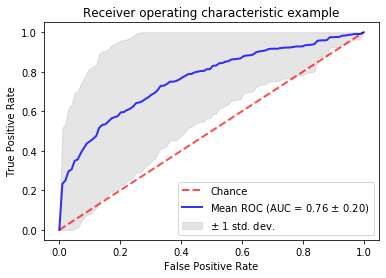

In [23]:
# %matplotlib notebook
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.7)

mean_tpr = np.nanmean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.nanstd(aucs)

ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.nanstd(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [252]:
print(accuracy_svm_total/DATASET_SIZE)
print(accuracy_rf_total/DATASET_SIZE)

0.6524300441826215
0.5661266568483063


In [24]:
print("----- SVM Confusion Matrix ------")
h = HTML(generate_HTML_CM(Confusion_Matrix_SVM))
display(h)

print("----- Random Forest Confusion Matrix ------")
h = HTML(generate_HTML_CM(Confusion_Matrix_RF))
display(h)

----- SVM Confusion Matrix ------


----- Random Forest Confusion Matrix ------
